In [1]:
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenetv2

# GPUのセットアップ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# データセットの読み込み
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = ImageFolder("data", data_transforms['train'])
dataset.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [3]:
# 訓練用、評価用にデータを分ける
all_size = len(dataset)
train_size = int(0.8 * all_size)
val_size = all_size - train_size
dataset_size  = {"train":train_size, "val":val_size}
train_data, val_data = random_split(dataset, [train_size, val_size])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


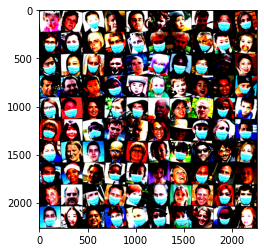

In [4]:
# DataLoaderを定義
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train':train_loader, 'val':val_loader}

dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(out.permute(1, 2, 0))

In [5]:
Model = mobilenetv2.mobilenet_v2(pretrained=True)

In [6]:
# パラメータをすべて取り出し、各層をフリーズさせる
for param in Model.parameters():
    param.requires_grad = False

In [7]:
# 今回の学習用に分類器を定義
Model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 2), 
                      nn.LogSoftmax(dim=1))

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)

In [9]:
#  CUBLAS_STATUS_ALLOC_FAILEDのエラー回避のために設定
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model=Model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_loss = 1.0
EPOCH = 200

#途中経過保存用に、リストを持った辞書を作ります。
loss_dict ={"train" : [],  "val" : []}
acc_dict = {"train" : [],  "val" : []}

# プログラム実行前に計算を最適化(GPUを使う場合)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

for epoch in range(EPOCH):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], labels).view(-1)
            running_corrects += torch.sum(correct).item()
        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_corrects / dataset_size[phase]
        loss_dict[phase].append(epoch_loss)
        acc_dict[phase].append(epoch_acc)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    if (epoch+1)%5 == 0:#５回に１回エポックを表示
        print('Epoch {}/{}'.format(epoch+1, EPOCH))
        print('-' * 10)

model.load_state_dict(best_model_wts)
print('Best val loss: {:.4f} acc: {:.4f}'.format(best_loss, best_acc))
print('Finished Training')

train Loss: 0.7013 Acc: 0.4950
val Loss: 0.6937 Acc: 0.5200
train Loss: 0.6980 Acc: 0.4950
val Loss: 0.6915 Acc: 0.5200
train Loss: 0.6945 Acc: 0.4953
val Loss: 0.6899 Acc: 0.5200
train Loss: 0.6932 Acc: 0.5022
val Loss: 0.6885 Acc: 0.5200
train Loss: 0.6907 Acc: 0.5275
val Loss: 0.6873 Acc: 0.5200
Epoch 5/200
----------
train Loss: 0.6891 Acc: 0.5666
val Loss: 0.6857 Acc: 0.5312
train Loss: 0.6872 Acc: 0.5950
val Loss: 0.6836 Acc: 0.7063
train Loss: 0.6853 Acc: 0.6106
val Loss: 0.6810 Acc: 0.9213
train Loss: 0.6838 Acc: 0.6153
val Loss: 0.6777 Acc: 0.9563
train Loss: 0.6794 Acc: 0.6547
val Loss: 0.6730 Acc: 0.9463
Epoch 10/200
----------
train Loss: 0.6738 Acc: 0.6684
val Loss: 0.6658 Acc: 0.9062
train Loss: 0.6669 Acc: 0.6922
val Loss: 0.6552 Acc: 0.8938
train Loss: 0.6539 Acc: 0.7675
val Loss: 0.6389 Acc: 0.9450
train Loss: 0.6398 Acc: 0.7884
val Loss: 0.6142 Acc: 0.9350
train Loss: 0.6128 Acc: 0.8512
val Loss: 0.5768 Acc: 0.9450
Epoch 15/200
----------
train Loss: 0.5734 Acc: 0.871

val Loss: 0.0040 Acc: 0.9975
train Loss: 0.0065 Acc: 0.9984
val Loss: 0.0029 Acc: 0.9988
train Loss: 0.0084 Acc: 0.9984
val Loss: 0.0072 Acc: 0.9988
train Loss: 0.0061 Acc: 0.9984
val Loss: 0.0115 Acc: 0.9962
Epoch 130/200
----------
train Loss: 0.0123 Acc: 0.9966
val Loss: 0.0019 Acc: 1.0000
train Loss: 0.0045 Acc: 0.9988
val Loss: 0.0086 Acc: 0.9975
train Loss: 0.0079 Acc: 0.9972
val Loss: 0.0041 Acc: 0.9975
train Loss: 0.0056 Acc: 0.9991
val Loss: 0.0050 Acc: 0.9988
train Loss: 0.0085 Acc: 0.9969
val Loss: 0.0066 Acc: 0.9962
Epoch 135/200
----------
train Loss: 0.0070 Acc: 0.9978
val Loss: 0.0094 Acc: 0.9988
train Loss: 0.0062 Acc: 0.9981
val Loss: 0.0076 Acc: 0.9975
train Loss: 0.0038 Acc: 0.9988
val Loss: 0.0067 Acc: 0.9962
train Loss: 0.0097 Acc: 0.9978
val Loss: 0.0008 Acc: 1.0000
train Loss: 0.0111 Acc: 0.9978
val Loss: 0.0070 Acc: 0.9975
Epoch 140/200
----------
train Loss: 0.0067 Acc: 0.9981
val Loss: 0.0138 Acc: 0.9962
train Loss: 0.0130 Acc: 0.9959
val Loss: 0.0106 Acc: 0.9

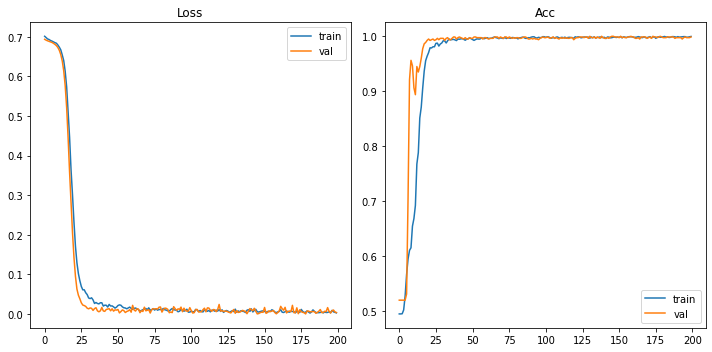

In [10]:
loss_train = loss_dict["train"]
loss_val   = loss_dict["val"]

acc_train = acc_dict["train"]
acc_val   = acc_dict["val"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#０個目のグラフ
axes[0].plot(range(EPOCH), loss_train, label = "train")
axes[0].plot(range(EPOCH), loss_val,    label =  "val")
axes[0].set_title("Loss")
axes[0].legend()#各グラフのlabelを表示

#１個目のグラフ
axes[1].plot(range(EPOCH), acc_train, label = "train")
axes[1].plot(range(EPOCH), acc_val,    label =  "val")
axes[1].set_title("Acc")
axes[1].legend()

#０個目と１個目のグラフが重ならないように調整
fig.tight_layout()

In [11]:
# モデルの保存(pth)
torch.save(model.to('cpu'),"detector/face_mask_detector.pth")

# モデルの保存(ONNX)
trained_model = torch.load('detector/face_mask_detector.pth')
dummy_input = torch.randn(1, 3, 224, 224) 
torch.onnx.export(trained_model, dummy_input, "detector/face_mask_detector.onnx") 

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
